In [52]:
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import scipy.fftpack as sfft
import plotly.express as px
import seaborn

### Authors: Janike Katter, Felix Reichling

### a)

Koeffizienten [ 0.  0.  0.  0.  1.  0. -1.  0.  1.  0. -1.  0.  0.  0.  0.  0.]


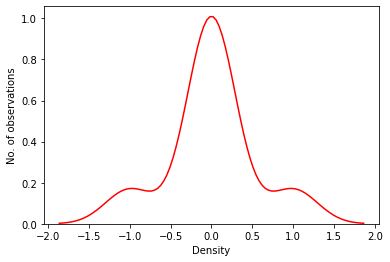

In [81]:
V1 = np.array([[0,0,0,0],
                [0,1,1,0],
                [0,1,1,0],
                [0,0,0,0]])

coefV1 = sfft.dct(V1, norm = 'ortho').reshape(16)
plt.xlabel('Density')
plt.ylabel('No. of observations')
seaborn.kdeplot(coefV1, color="r")
print('Koeffizienten', coefV1)

$P_4(s,t) = 2/4 \cdot \big(1/ \sqrt{2} \cdot \cos{\frac{\pi (2s+1)}{8}} + (-1) \cdot \cos{\frac{\pi (2s+1)}{8}} \cos{\frac{2\pi (2t+1)}{8}} + 1/ \sqrt{2} \cdot \cos{\frac{2\pi (2s+1)}{8}} + (-1) \cdot \cos{\frac{2\pi (2s+1)}{8}} \cos{\frac{2\pi (2t+1)}{8}}\big)$

Koeffizienten [6. 0. 0. 0. 2. 0. 4. 0. 6. 0. 0. 0. 2. 0. 4. 0.]


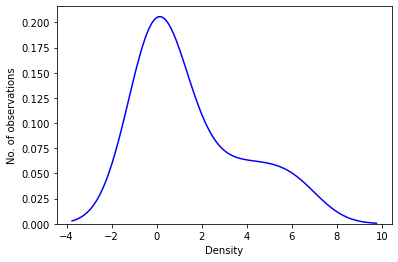

In [82]:
V2 = np.array([[3,3,3,3],
                [3,-1,-1,3],
                [3,3,3,3],
                [3,-1,-1,3]])

coefV2 = sfft.dct(V2, norm = 'ortho').reshape(16)
plt.xlabel('Density')
plt.ylabel('No. of observations')
seaborn.kdeplot(coefV2, color="b")
print('Koeffizienten', coefV2)


$P_4(s,t) = 2/4 \cdot \big(1/ \sqrt{2} \cdot \cos{\frac{\pi (2s+1)}{8}} + (-1) \cdot \cos{\frac{\pi (2s+1)}{8}} \cos{\frac{2\pi (2t+1)}{8}} + 1/ \sqrt{2} \cdot \cos{\frac{2\pi (2s+1)}{8}} + (-1) \cdot \cos{\frac{2\pi (2s+1)}{8}} \cos{\frac{2\pi (2t+1)}{8}}\big)$

### b)

In [3]:
# Quantisierungsmatrix aus dem Lesetext
Q1 = np.array([[8,16,24,32,40,48,56,64],
        [16,24,32,40,48,56,64,72],
        [24,32,40,48,56,64,72,80],
        [32,40,48,56,64,72,80,88],
        [40,48,56,64,72,80,88,96],
        [48,56,64,72,80,88,96,104],
        [56,64,72,80,88,96,104,112],
        [64,72,80,88,96,104,112,120]])
    
# Q aus Aufgabe 2
Q2 = np.array([[16,11,10,16,24,40,51,61],
        [12,12,14,19,26,58,60,55],
        [14,13,16,24,40,57,69,56],
        [14,17,22,29,51,87,80,62],
        [18,22,37,56,68,109,103,77],
        [24,35,55,64,81,104,113,92],
        [49,64,78,87,103,121,120,101],
        [72,92,95,98,112,100,103,99]])

In [4]:
def encode_quant(orig, quant):
    return (orig / quant).astype(np.int)

def decode_quant(orig, quant):
    return (orig * quant).astype(float)


def encode_dct(orig, bx, by):
    new_shape = (
        orig.shape[0] // bx * bx,
        orig.shape[1] // by * by
    )
    new = orig[
        :new_shape[0],
        :new_shape[1]
    ].reshape((
        new_shape[0] // bx,
        bx,
        new_shape[1] // by,
        by
    ))
    return sfft.dctn(new, axes=[1,3], norm='ortho')

def decode_dct(orig, bx, by):
    return sfft.idctn(orig, axes=[1,3], norm='ortho'
    ).reshape((
        orig.shape[0]*bx,
        orig.shape[2]*by
    ))

In [14]:
def quant1(V8,p,Q):
    
    new_shape = (
        V8.shape[0] // 8 * 8,
        V8.shape[1] // 8 * 8
    )
    new = V8[
        :new_shape[0],
        :new_shape[1]
    ].reshape((
        new_shape[0] // 8,
        8,
        new_shape[1] // 8,
        8
    ))
    enc = sfft.dct(new, norm='ortho')
    ''' #Only for no quantisation
    quant = (
                (np.ones((8,8))
                 .clip(-100,100)
                 .reshape((1,8,1,8)))
                )
    '''
    quant = (
                ((Q * (p)))
                .clip(-100, 100)  # to prevent clipping
                .reshape((1,8,1,8))
            )
    
    encq = encode_quant(enc, quant)
    decq = decode_quant(encq, quant)
    r = sfft.idct(decq,norm = 'ortho')
    dec =r.reshape((
        decq.shape[0]*8,
        decq.shape[2]*8
    ))

    reconstructed = Image.fromarray(dec.astype(np.uint8),'L')
    plt.figure()
    plt.title(f'compressed p = {p}')
    plt.imshow(reconstructed, cmap = plt.get_cmap('Greys_r'))
    plt.show()

    

In [15]:
testpic = Image.open('TestBild2.jpg')

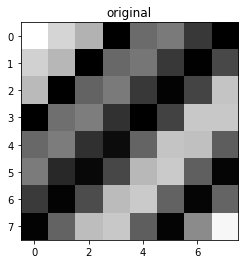

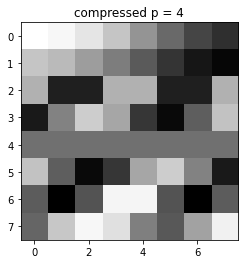

In [16]:
plt.figure()
plt.title('original')
plt.imshow(testpic, cmap = plt.get_cmap('Greys_r'))
picAr = np.array(testpic)
p = 4
quant1(picAr,p,Q1)

In [8]:
# Load image
lena = Image.open('lena.jpg')

In [9]:
def quant2(x, quants, blocksize, Q):
    decs = []

    for qscale in quants:
        for bx,by in blocksize:
            quant = (
                    ((Q * (qscale)))
                    .clip(-100, 100)  # to prevent clipping
                    .reshape((1, bx, 1, by))
                )

        enc = encode_dct(x,bx,by)
        encq = encode_quant(enc, quant)
        decq = decode_quant(encq, quant)
        dec = decode_dct(decq, bx, by)

        decs.append((dec,qscale))
        
    for i in decs:
        reconstructed = Image.fromarray(i[0].astype(np.uint8),'L')
        p = i[1]
        plt.figure()
        plt.title(f'p = {p}')
        plt.imshow(reconstructed, cmap = plt.get_cmap('Greys_r'))
        plt.show()


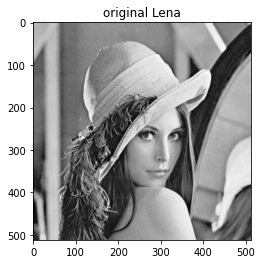

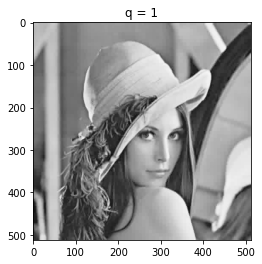

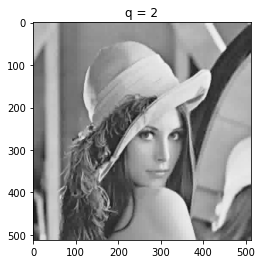

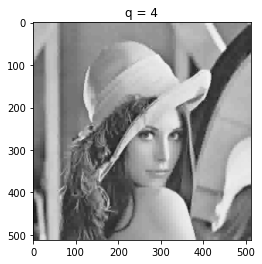

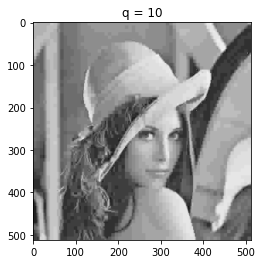

In [18]:
plt.figure()
plt.title('original Lena')
plt.imshow(lena, cmap = plt.get_cmap('Greys_r'))
x = np.array(lena)


quants = [1,2,4,10] # p values
blocksize = [(8,8)] # block size 8x8
quant2(x, quants, blocksize, Q1)